# **Loading data**

In [17]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
                                        LogisticRegressionModel, RandomForestClassificationModel, GBTClassificationModel
from time import time

spark = SparkSession.builder.appName('SIMARGL2021').getOrCreate()

# **Data preprocessing**

In [6]:
base_df = spark.read.csv("SIMARGL2021.csv", header=True, inferSchema=True)
base_df.show(2)

+----------------+---------+-----------------------+--------------+--------------+-------------------+--------------------------+--------------------------+---------------------+------------+--------+---------------------+-----------------------+--------------+------------+--------+-------+--------------+--------------+-----------+-----------+-------------+--------------+--------------+---------------+----------------+---------+--------+--------+------------+----------------------+---------------------+-----------------------+----------------------+-----------------------+---------+--------------+---------------+--------------+---------------+--------------+---------------+----------------+-----------------+-------+-------+--------------+-----------------+---------------+-----------+
|BIFLOW_DIRECTION|DIRECTION|DST_TO_SRC_SECOND_BYTES|FIREWALL_EVENT|FIRST_SWITCHED|FLOW_ACTIVE_TIMEOUT|FLOW_DURATION_MICROSECONDS|FLOW_DURATION_MILLISECONDS|FLOW_END_MILLISECONDS|FLOW_END_SEC| FLOW_ID|FLOW_

In [7]:
df = base_df
df.printSchema()

root
 |-- BIFLOW_DIRECTION: integer (nullable = true)
 |-- DIRECTION: integer (nullable = true)
 |-- DST_TO_SRC_SECOND_BYTES: string (nullable = true)
 |-- FIREWALL_EVENT: integer (nullable = true)
 |-- FIRST_SWITCHED: integer (nullable = true)
 |-- FLOW_ACTIVE_TIMEOUT: integer (nullable = true)
 |-- FLOW_DURATION_MICROSECONDS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- FLOW_END_MILLISECONDS: long (nullable = true)
 |-- FLOW_END_SEC: integer (nullable = true)
 |-- FLOW_ID: integer (nullable = true)
 |-- FLOW_INACTIVE_TIMEOUT: integer (nullable = true)
 |-- FLOW_START_MILLISECONDS: long (nullable = true)
 |-- FLOW_START_SEC: integer (nullable = true)
 |-- FRAME_LENGTH: integer (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- L4_SRC_PORT: integer (nullable

In [8]:
df.count()

8637207

In [9]:
df2 = df.na.drop()
df2.count()

8637207

In [10]:
from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCols=["IPV4_SRC_ADDR", "IPV4_DST_ADDR", "PROTOCOL_MAP", "L7_PROTO_NAME", "LABEL"], outputCols=["IPV4_SRC_ADDR_Index", "IPV4_DST_ADDR_Index", "PROTOCOL_MAP_Index", "L7_PROTO_NAME_Index", "LABEL_Index"])
si_fit = si.fit(df)


df_indexed = si_fit.transform(df)

In [11]:
df = df_indexed.drop("LABEL", "IPV4_SRC_ADDR", "IPV4_DST_ADDR", "DST_TO_SRC_SECOND_BYTES", "PROTOCOL_MAP", "SRC_TO_DST_SECOND_BYTES", "L7_PROTO_NAME", "BIFLOW_DIRECTION", "DIRECTION", "FLOW_ACTIVE_TIMEOUT", "FIREWALL_EVENT", "FLOW_INACTIVE_TIMEOUT", "FRAME_LENGTH", "MAX_IP_PKT_LEN", "MIN_IP_PKT_LEN", "SAMPLING_INTERVAL", "FLOW_START_SEC", "FLOW_END_SEC", "FLOW_DURATION_MICROSECONDS", "FLOW_ID", "OOORDER_IN_PKTS", "OOORDER_OUT_PKTS")
df.printSchema()

root
 |-- FIRST_SWITCHED: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- FLOW_END_MILLISECONDS: long (nullable = true)
 |-- FLOW_START_MILLISECONDS: long (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- LAST_SWITCHED: integer (nullable = true)
 |-- OUT_BYTES: long (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- RETRANSMITTED_IN_BYTES: integer (nullable = true)
 |-- RETRANSMITTED_IN_PKTS: integer (nullable = true)
 |-- RETRANSMITTED_OUT_BYTES: integer (nullable = true)
 |-- RETRANSMITTED_OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- TCP_WIN_MAX_IN: integer (nullable = true)
 |-- TCP_WIN_MAX_OUT: integer (nullable = true)
 |-- TCP_WIN_MIN_IN: integer (nullable = true)
 |-- TCP_WIN_MIN_OUT: integer (nullable = tru

# Correlation Matrix

In [12]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

corr = Correlation.corr(df_vector, vector_col)

matrix = corr.collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df.columns, index=df.columns) 
corr_matrix_df.style.background_gradient(cmap='coolwarm')

,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OUT_BYTES,OUT_PKTS,PROTOCOL,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_FLAGS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,IPV4_SRC_ADDR_Index,IPV4_DST_ADDR_Index,PROTOCOL_MAP_Index,L7_PROTO_NAME_Index,LABEL_Index
FIRST_SWITCHED,1.000000,0.162694,0.999997,1.000000,-0.006413,-0.004517,-0.051627,-0.041850,0.999997,-0.001023,-0.002079,-0.131243,-0.024126,0.010513,0.011986,0.012259,0.174129,0.082339,0.118535,0.082912,0.118995,0.062505,0.192049,0.051354,0.204915,-0.061782,-0.097314,0.950147,-0.048534,-0.020652,-0.173386,-0.080895,0.312277
FLOW_DURATION_MILLISECONDS,0.162694,1.000000,0.165094,0.162694,0.014288,0.019655,-0.216952,-0.053719,0.165093,0.004375,0.007986,-0.302953,0.044909,0.384324,-0.011223,-0.011038,0.423331,0.000326,0.039940,0.001416,0.040517,-0.043160,0.099153,-0.027111,0.113693,-0.173051,-0.152401,0.122318,-0.099859,-0.123444,-0.362969,-0.181945,0.624942
FLOW_END_MILLISECONDS,0.999997,0.165094,1.000000,0.999997,-0.006375,-0.004467,-0.052141,-0.041966,1.000000,-0.001012,-0.002059,-0.131938,-0.024006,0.011456,0.011953,0.012227,0.175103,0.082307,0.118586,0.082883,0.119047,0.062373,0.192217,0.051267,0.205113,-0.062184,-0.097651,0.950065,-0.048760,-0.020948,-0.174211,-0.081311,0.313692
FLOW_START_MILLISECONDS,1.000000,0.162694,0.999997,1.000000,-0.006413,-0.004517,-0.051627,-0.041850,0.999997,-0.001023,-0.002080,-0.131243,-0.024126,0.010513,0.011986,0.012259,0.174129,0.082339,0.118535,0.082913,0.118995,0.062505,0.192050,0.051354,0.204915,-0.061782,-0.097314,0.950147,-0.048534,-0.020652,-0.173386,-0.080895,0.312277
IN_BYTES,-0.006413,0.014288,-0.006375,-0.006413,1.000000,0.803119,0.006779,-0.002362,-0.006375,0.063159,0.210766,0.003860,0.034934,0.020215,0.004842,0.004839,0.000170,0.003532,0.016583,0.003457,0.016546,0.002821,0.005620,0.002721,0.005824,-0.003528,-0.000139,-0.006463,-0.000895,-0.001927,0.000653,0.027399,-0.008031
IN_PKTS,-0.004517,0.019655,-0.004467,-0.004517,0.803119,1.000000,0.005942,-0.003057,-0.004467,0.571169,0.707349,0.002161,0.026904,0.016319,0.084243,0.084185,0.003884,0.006605,0.020426,0.006431,0.020365,0.005301,0.010040,0.005249,0.010244,-0.004870,-0.000363,-0.004553,-0.001497,-0.003171,-0.002150,0.030731,-0.007318
L4_DST_PORT,-0.051627,-0.216952,-0.052141,-0.051627,0.006779,0.005942,1.000000,-0.054245,-0.052141,0.001190,0.001252,0.205233,-0.009005,-0.062357,-0.010545,-0.010313,-0.167271,-0.103364,-0.210682,-0.102250,-0.210528,-0.088296,-0.235629,-0.088218,-0.245189,0.049643,0.014460,-0.054896,0.095110,0.465629,0.080574,0.004016,-0.293805
L4_SRC_PORT,-0.041850,-0.053719,-0.041966,-0.041850,-0.002362,-0.003057,-0.054245,1.000000,-0.041966,-0.000740,-0.001013,0.234348,0.004136,0.044342,-0.006856,-0.007472,0.028641,0.086947,0.022572,0.085792,0.022285,0.084763,-0.000466,0.095595,-0.008663,-0.215387,0.132924,-0.052349,-0.098551,0.105494,-0.247178,0.032835,-0.031599
LAST_SWITCHED,0.999997,0.165093,1.000000,0.999997,-0.006375,-0.004467,-0.052141,-0.041966,1.000000,-0.001012,-0.002059,-0.131937,-0.024006,0.011456,0.011953,0.012227,0.175102,0.082307,0.118586,0.082883,0.119047,0.062374,0.192217,0.051267,0.205113,-0.062184,-0.097651,0.950065,-0.048760,-0.020948,-0.174211,-0.081311,0.313692
OUT_BYTES,-0.001023,0.004375,-0.001012,-0.001023,0.063159,0.571169,0.001190,-0.000740,-0.001012,1.000000,0.931187,-0.000981,0.001086,-0.000351,0.143005,0.143121,0.003783,0.006209,0.012077,0.005869,0.012055,0.005275,0.007564,0.004865,0.007477,-0.001900,-0.000317,-0.000830,-0.000441,-0.001051,-0.002562,0.010524,-0.005866


In [13]:
final_df = df.select(["FLOW_DURATION_MILLISECONDS", "TCP_FLAGS", "TCP_WIN_MAX_IN", "TCP_WIN_MIN_IN", "TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_OUT", "LABEL_Index"])
final_df.show(5)

+--------------------------+---------+--------------+--------------+---------------+-----------------+-----------+
|FLOW_DURATION_MILLISECONDS|TCP_FLAGS|TCP_WIN_MAX_IN|TCP_WIN_MIN_IN|TCP_WIN_MSS_OUT|TCP_WIN_SCALE_OUT|LABEL_Index|
+--------------------------+---------+--------------+--------------+---------------+-----------------+-----------+
|                    104116|       19|         64240|          8192|           1460|                0|        0.0|
|                      9529|        0|             0|             0|              0|                0|        0.0|
|                      9529|        0|             0|             0|              0|                0|        0.0|
|                         0|        0|             0|             0|              0|                0|        0.0|
|                         0|        2|         65535|         65535|              0|                0|        0.0|
+--------------------------+---------+--------------+--------------+------------

In [14]:
final_df.repartition(1).write.option("header", True).csv("df")

## ML Algorithms

In [2]:
df = spark.read.csv("processedData.csv", header=True, inferSchema=True)
df.show(5)

+--------------------------+---------+--------------+--------------+---------------+-----------------+-----------+
|FLOW_DURATION_MILLISECONDS|TCP_FLAGS|TCP_WIN_MAX_IN|TCP_WIN_MIN_IN|TCP_WIN_MSS_OUT|TCP_WIN_SCALE_OUT|LABEL_Index|
+--------------------------+---------+--------------+--------------+---------------+-----------------+-----------+
|                    104116|       19|         64240|          8192|           1460|                0|        0.0|
|                      9529|        0|             0|             0|              0|                0|        0.0|
|                      9529|        0|             0|             0|              0|                0|        0.0|
|                         0|        0|             0|             0|              0|                0|        0.0|
|                         0|        2|         65535|         65535|              0|                0|        0.0|
+--------------------------+---------+--------------+--------------+------------

Assemble vector

In [3]:
df = df.limit(8_500_000)

input_cols = df.columns
input_cols.remove("LABEL_Index")

assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
output = assembler.transform(df)

final_data = output.select(["features", "LABEL_Index"])

Training data and testing data split

In [4]:
trainData, testData = final_data.randomSplit([0.7, 0.3], seed = 16)

In [5]:
trainData.describe().show()
testData.describe().show()

+-------+-------------------+
|summary|        LABEL_Index|
+-------+-------------------+
|  count|            5950730|
|   mean|0.47126923923619457|
| stddev| 0.6726729031675439|
|    min|                0.0|
|    max|                2.0|
+-------+-------------------+

+-------+------------------+
|summary|       LABEL_Index|
+-------+------------------+
|  count|           2549270|
|   mean|0.4709814966637508|
| stddev|0.6726423069627532|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



# Logistic Regression

In [6]:
lr = LogisticRegression(labelCol='LABEL_Index')

startTime = time()

lr_model = lr.fit(trainData)

endTime = time()
print(f"{endTime - startTime} seconds")

64.44638800621033 seconds


In [8]:
lr_model.save("LR_Model")

In [9]:
lr_model = LogisticRegressionModel.load("LR_Model")

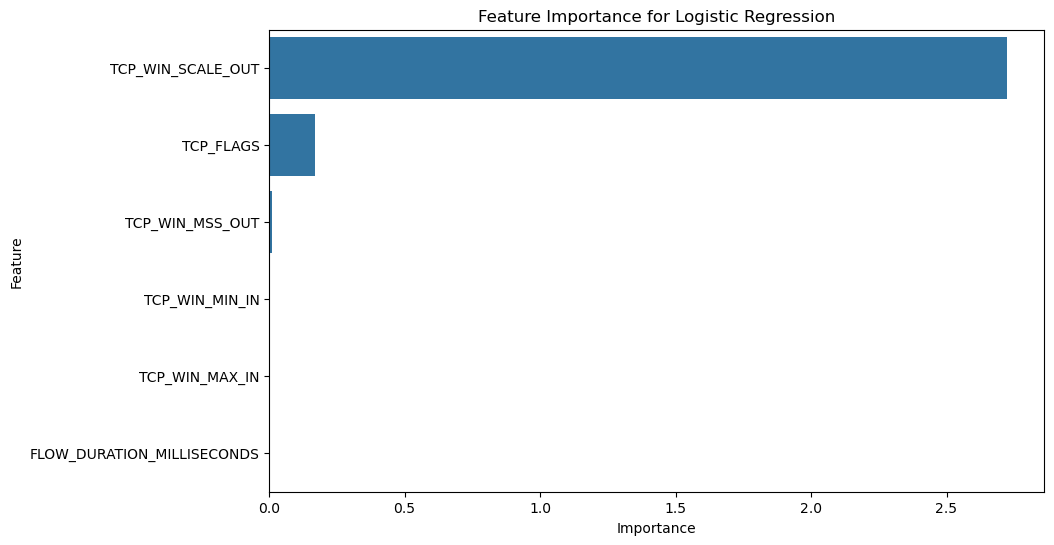

In [10]:
coefficients = lr_model.coefficientMatrix.toArray()

feature_names = ["FLOW_DURATION_MILLISECONDS", "TCP_FLAGS", "TCP_WIN_MAX_IN", "TCP_WIN_MIN_IN", "TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_OUT"]

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients).sum(axis=0)
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Metrics

In [19]:
predictions = lr_model.transform(testData)
predictions.show()

+---------+-----------+--------------------+--------------------+----------+
| features|LABEL_Index|       rawPrediction|         probability|prediction|
+---------+-----------+--------------------+--------------------+----------+
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|
|(6,[],[])|        0.0|[25.9860608831998...|[0.98235497887442...|       0.0|

In [20]:
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(DoubleType()))
predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["LABEL_Index"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["LABEL_Index"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["LABEL_Index"] == 0), 2) \
                                                .otherwise(3))

tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 393945
 False Positives: 182140
 False Negatives: 58883
 True Negatives: 1914302


In [21]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.9054541103923869
 Precision: 0.6838313790499666
 Recall: 0.8699660798360526
 F1-Score: 0.7657498738960438


### Random Forest Classifier

In [23]:
rf = RandomForestClassifier(labelCol='LABEL_Index')

startTime = time()

rf_model = rf.fit(trainData)

endTime = time()
print(f"{endTime - startTime} seconds")

121.13925790786743 seconds


Model Checkpoint

In [24]:
rf_model.save("RF_Model")

In [25]:
rf_model = RandomForestClassificationModel.load("RF_Model")

Feature importance

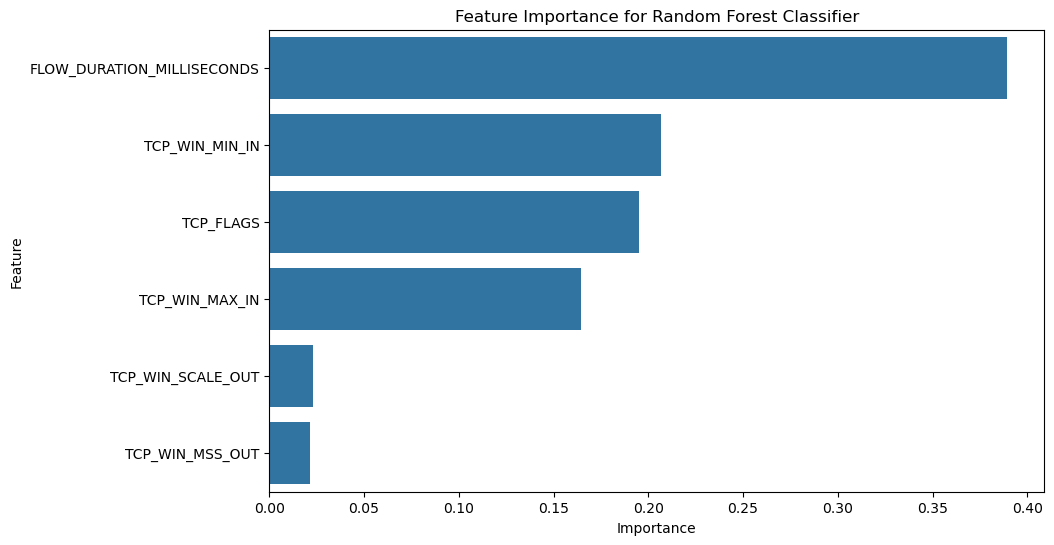

In [26]:
importances = rf_model.featureImportances.toArray()
feature_names = ["FLOW_DURATION_MILLISECONDS", "TCP_FLAGS", "TCP_WIN_MAX_IN", "TCP_WIN_MIN_IN", "TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_OUT"]

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Metrics computation

In [29]:
predictions = rf_model.transform(testData)
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(DoubleType()))

predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["LABEL_Index"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["LABEL_Index"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["LABEL_Index"] == 0), 2) \
                                                .otherwise(3))

tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 661327
 False Positives: 1450
 False Negatives: 723
 True Negatives: 1885770


In [30]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1-Score: {f1_score}"
)

Accuracy: 0.9991475991166099
 Precision: 0.9978122354879545
 Recall: 0.9989079374669587
 F1-Score: 0.9983597858437366
